In [1]:
%config IPCompleter.use_jedi = False
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
np.set_printoptions(precision=4)

from pathlib import Path
fig_path = str(Path().absolute())+'/figures/hw3/'
print(fig_path)
data_path = str(Path().absolute())+'/hw3/data/'
print(data_path)

/home/zpyang/grad_courses/2021_spring/ece595_ml/figures/hw3/
/home/zpyang/grad_courses/2021_spring/ece595_ml/hw3/data/


# Exercise 2

In [2]:
train_cat = pd.read_csv(data_path+"train_cat.txt", delimiter=',', header=None)
train_cat = np.matrix(train_cat)
train_grass = pd.read_csv(data_path+"train_grass.txt", delimiter=',', header=None)
train_grass = np.matrix(train_grass)
n_cat = train_cat.shape[1]
n_grass = train_grass.shape[1]

## 2 a)
$$
P_{Y|X}(C_1|x) \gtrless^{C_1}_{C_0} P_{Y|X}(C_0|x) \\
$$
$$
P_{X|Y}(x|C_1) \cdot P_{Y}(C_1) \gtrless^{C_1}_{C_0} P_{X|Y}(x|C_0) \cdot P_{Y}(C_1) \\
$$
$$
\frac{1}{(2\pi)^{d/2}|\Sigma_1|^{1/2}}\exp{\{-1/2(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1)\}}\cdot \pi_1
\gtrless^{C_1}_{C_0}
\frac{1}{(2\pi)^{d/2}|\Sigma_0|^{1/2}}\exp{\{-1/2(x-\mu_0)^T\Sigma_1^{-1}(x-\mu_0)\}}\cdot \pi_0\\
$$
taking $\log(\cdot)$ on both sides
$$
-\frac{d}{2}\log{(2\pi)} - \frac{1}{2}\log{|\Sigma_1|} - \frac{1}{2}(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1) + \log{(\pi_1)}
\gtrless^{C_1}_{C_0}
-\frac{d}{2}\log{(2\pi)} - \frac{1}{2}\log{|\Sigma_0|} - \frac{1}{2}(x-\mu_0)^T\Sigma_0^{-1}(x-\mu_0) + \log{(\pi_0)}\\
$$
$\frac{d}{2}\log{(2\pi)}$ terms cancel out on both sides
$$
\boxed{
- \frac{1}{2}(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1) + \log{(\pi_1)} - \frac{1}{2}\log{|\Sigma_1|}
\gtrless^{C_1}_{C_0}
- \frac{1}{2}(x-\mu_0)^T\Sigma_0^{-1}(x-\mu_0) + \log{(\pi_0)} - \frac{1}{2}\log{|\Sigma_0|}
}
$$

In [3]:
K1 = train_cat.shape[1]
K0 = train_grass.shape[1]

pi1 = K1/(K1+K0)
pi0 = K0/(K1+K0)

mu1 = np.mean(train_cat,axis=1)
mu0 = np.mean(train_grass, axis=1)

SIG1 = 1/n_cat*sum([(train_cat[:,i]-mu1)*(train_cat[:,i]-mu1).T for i in range(n_cat)])
SIG0 = 1/n_grass*sum([(train_grass[:,i]-mu0)*(train_grass[:,i]-mu0).T for i in range(n_grass)])

print('mu1[0:2]:',mu1[0:2].T)
print('mu0[0:2]:',mu0[0:2].T)
print('____________________')
print('SIG1[0:2,0:2]:\n',SIG1[0:2,0:2])
print('SIG0[0:2,0:2]:\n',SIG0[0:2,0:2])
print('____________________')
print('pi_1:', pi1)
print('pi_0:', pi0)

mu1[0:2]: [[0.4408 0.4387]]
mu0[0:2]: [[0.4825 0.4864]]
____________________
SIG1[0:2,0:2]:
 [[0.0431 0.0353]
 [0.0353 0.0425]]
SIG0[0:2,0:2]:
 [[0.0645 0.0369]
 [0.0369 0.0662]]
____________________
pi_1: 0.171349288935137
pi_0: 0.828650711064863


In [4]:
invSIG1 = np.linalg.inv(SIG1)
invSIG0 = np.linalg.inv(SIG0)
detSIG1 = np.linalg.det(SIG1)
detSIG0 = np.linalg.det(SIG0)

k1 = np.log(pi1) - 1/2*np.log(detSIG1)
k0 = np.log(pi0) - 1/2*np.log(detSIG0)

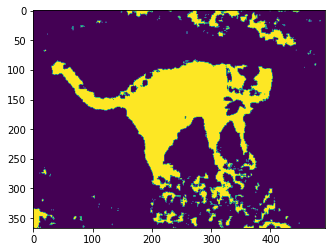

In [5]:
def decision(mu, invSIG, k, x):
    return -1/2*(x-mu).T @ invSIG @ (x-mu) + k

Y = plt.imread(data_path+"cat_grass.jpg")/255
M,N = Y.shape
pred = np.zeros((M-8,N-8))
tau_vec = []
for i in range(M-8):
    for j in range(N-8):
        block = Y[i:i+8, j:j+8]
        x = block.reshape(1,-1).T
        d1 = decision(mu1, invSIG1, k1, x)
        d0 = decision(mu0, invSIG0, k0, x)
        if d1 > d0 :
            pred[i,j] = 1
pred=pred.astype('int32')
plt.imshow(pred)


## 2 d)

In [6]:
truth = plt.imread(data_path+"truth.png")
print(np.sum(truth))
truth = truth.astype('int32')
print(np.sum(truth))
truth = truth[0:M-8,0:N-8]

MAE = 1/((M-8)*(N-8))*np.sum(np.abs(pred-truth))
print('MAE',MAE)

31598.99
30073
MAE 0.0897521100551605


In [7]:
TP = np.sum(np.floor(((truth + pred)/2)))
PD_bd = TP/np.sum(truth)

FP = np.sum(pred)-TP
PF_bd = FP/((M-8)*(N-8)-np.sum(truth))
print('PD_bd', PD_bd)
print('PF_bd', PF_bd)

PD_bd 0.8346357197486117
PF_bd 0.0746423374155265


## 2 e)

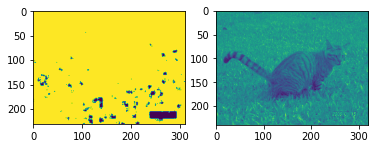

In [8]:
Y = plt.imread(data_path+"cat_grass_2.jpeg")/255
Y = Y[:,:,2]
M,N = Y.shape
pred_1 = np.zeros((M-8,N-8))
for i in range(M-8):
    for j in range(N-8):
        block = Y[i:i+8, j:j+8]
        x = block.reshape(1,-1).T
        if decision(mu1, invSIG1, k1, x) > decision(mu0, invSIG0, k0, x):
            pred_1[i,j] = 1
plt.subplot(1,2,1)
plt.imshow(pred_1)
plt.subplot(1,2,2)
plt.imshow(Y[:,:])
plt.show()

# 

# Exercise 3

## 3 a)

$$
P_{Y|X}(C_1|x) \gtrless P_{Y|X}(C_0|x)\\
$$

$$
P_{X|Y}(x|C_1)\pi_1 \gtrless P_{X|Y}(x|C_0)\pi_0 \\
$$

$$
\frac{P_{X|Y}(x|C_1)}{P_{X|Y}(x|C_0)} \gtrless \frac{\pi_0}{\pi_1} = \tau\\
$$

In [9]:
tau = pi0/pi1
print('tau:',tau)
np.log(tau)

tau: 4.836032388663967


1.5760946301378869

## 3 b)
ass

In [23]:
from tqdm.notebook import tqdm

Y = plt.imread(data_path+"cat_grass.jpg")/255
M,N = Y.shape

c = 1/2*(np.log(detSIG0)-np.log(detSIG1))

def likelihood_ratio(x, mu0, mu1, invSIG0, invSIG1, c):
    return (-0.5*(x-mu1).T @ invSIG1 @ (x-mu1) + 0.5*(x-mu0).T @ invSIG0 @ (x-mu0)) + c

tau_calc_mat = np.zeros((M-8,N-8))
for i in range(M-8):
    for j in range(N-8):
        block = Y[i:i+8, j:j+8]
        x = block.reshape(1,-1).T
        tau_calc_mat[i,j] = likelihood_ratio(x, mu0, mu1, invSIG0, invSIG1, c)
print("tau_calc_mat done")

tau_calc_mat done


  0%|          | 0/1000 [00:00<?, ?it/s]

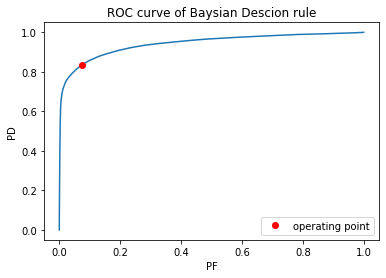

In [27]:
# 3 c)
n = 1000
tau_vec = np.linspace(-400,50,n)

PD = np.zeros(n)
PF = np.zeros(n)

truth = plt.imread(data_path+"truth.png")
truth = truth[0:M-8,0:N-8]
truth_int = truth.astype('int32')
truth = truth_int.astype('bool')

for k in tqdm(range(n)):
    pred = tau_calc_mat > tau_vec[k]

    TP = np.sum((pred & truth))
    PD[k] = TP/np.sum(truth)

    FP = np.sum(pred)-TP
    PF[k] = FP/((M-8)*(N-8)-np.sum(truth))

plt.plot(PF, PD)
plt.plot(PF_bd, PD_bd, 'ro', label='operating point')
plt.xlabel('PF')
plt.ylabel('PD')
plt.title('ROC curve of Baysian Descion rule')
plt.legend()

In [26]:
print(np.sum(truth))
print(np.sum(truth_int))

30073
30073


## 3 d)

In [32]:
X1 = train_cat.T
X0 = train_grass.T
A = np.vstack((X1,X0))
b = np.hstack((np.ones(K1),-np.ones(K0)))
theta = np.linalg.lstsq(A,b, rcond=None)[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'ROC curve of linear regression')

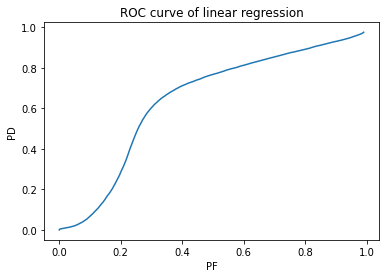

In [41]:
tau_calc_mat = np.zeros((M-8,N-8))
for i in range(M-8):
    for j in range(N-8):
        block = Y[i:i+8, j:j+8]
        x = block.reshape(1,-1).T
        d = theta.T @ x
        tau_calc_mat[i,j] = theta.T @ x

n = 1000
tau_vec = np.linspace(-1,0,n)
PD_lr = np.zeros(n)
PF_lr = np.zeros(n)
for k in tqdm(range(n)):
    pred = tau_calc_mat > tau_vec[k]

    TP = np.sum((pred & truth))
    PD_lr[k] = TP/np.sum(truth)

    FP = np.sum(pred)-TP
    PF_lr[k] = FP/((M-8)*(N-8)-np.sum(truth))

plt.plot(PF_lr, PD_lr)
plt.xlabel('PF')
plt.ylabel('PD')
plt.title('ROC curve of linear regression')